In [1]:
import tensorflow as tf
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
from os import path
import shutil
from keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa



dtype = torch.float
device = torch.device("cpu")

In [2]:
tf.__version__

'2.8.0'

In [3]:

#src = "chest_xray/train/PNEUMONIA"
#dst1 = "chest_xray/train/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/train/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)


In [4]:
#src = "chest_xray/test/PNEUMONIA"
#dst1 = "chest_xray/test/PNEUMONIA_BACTERIAL"
#dst2 = "chest_xray/test/PNEUMONIA_VIRUS"
#files_bacteria = [i for i in os.listdir(src) if "bacteria" in i and path.isfile(path.join(src, i))]
#files_virus = [i for i in os.listdir(src) if "virus" in i and path.isfile(path.join(src, i))]


#for f in files_bacteria:
 #   shutil.move(path.join(src, f), dst1)

#for f in files_virus:
 #   shutil.move(path.join(src, f), dst2)

In [5]:
data_dir = './chest_xray/train'
img_height = 180
img_width = 180
batchSize =32

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height,img_width),
                                                       batch_size=batchSize
                                                      )


Found 5232 files belonging to 3 classes.
Using 4186 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batchSize)

Found 5232 files belonging to 3 classes.
Using 1046 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRUS']


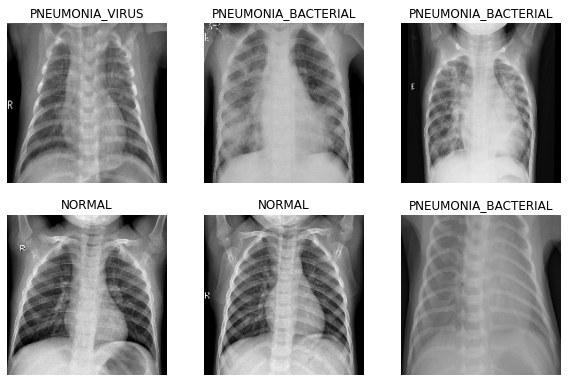

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normal_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))#
val_normal_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
#train_ds = normal_ds
#val_ds = val_normal_ds
#image_batch, labels_batch = next(iter(train_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [13]:
data_augmentation = keras.Sequential(
  [
    #layers.RandomFlip("horizontal",input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

In [14]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (2,2), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (8,8), strides=(1, 1), padding='same'),
   layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2DTranspose(64, 3, strides=(4,4), padding='same',activation='relu'),
  #layers.MaxPooling2D(pool_size = (16,16), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (8,8), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(pool_size = (4,4), strides=(1, 1), padding='same'),
    layers.MaxPooling2D(),
  layers.BatchNormalization(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  #layers.BatchNormalization(),
    layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,),
              #optimizer=tf.keras.optimizers.Adam(),
                #loss=tf.keras.losses.binary_crossentropy,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [17]:
#tf.config.set_soft_device_placement(True) 
with tf.device('/cpu:0'):   
    epochs=200
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size = batchSize,
      #shuffle = True
    
    


    )
#sess = tf.Session(config=tf.ConfigProto(
 #     allow_soft_placement=True, log_device_placement=True))

#print(sess.run(history))

Epoch 1/200
131/131 [==============================] - 49s 331ms/step - loss: 0.9933 - accuracy: 0.5822 - val_loss: 1.0740 - val_accuracy: 0.5019
Epoch 2/200
131/131 [==============================] - 43s 325ms/step - loss: 0.7697 - accuracy: 0.6639 - val_loss: 1.5856 - val_accuracy: 0.5019
Epoch 3/200
131/131 [==============================] - 42s 324ms/step - loss: 0.7042 - accuracy: 0.6971 - val_loss: 1.8723 - val_accuracy: 0.5019
Epoch 4/200
131/131 [==============================] - 42s 323ms/step - loss: 0.6753 - accuracy: 0.7033 - val_loss: 0.7647 - val_accuracy: 0.6424
Epoch 5/200
131/131 [==============================] - 43s 328ms/step - loss: 0.6392 - accuracy: 0.7229 - val_loss: 0.8089 - val_accuracy: 0.6597
Epoch 6/200
131/131 [==============================] - 41s 314ms/step - loss: 0.6262 - accuracy: 0.7222 - val_loss: 0.6637 - val_accuracy: 0.7361
Epoch 7/200
131/131 [==============================] - 41s 314ms/step - loss: 0.6203 - accuracy: 0.7379 - val_loss: 0.9206 -

Epoch 57/200
131/131 [==============================] - 41s 314ms/step - loss: 0.4551 - accuracy: 0.7974 - val_loss: 0.6320 - val_accuracy: 0.7342
Epoch 58/200
131/131 [==============================] - 42s 318ms/step - loss: 0.4542 - accuracy: 0.8000 - val_loss: 0.5490 - val_accuracy: 0.7734
Epoch 59/200
131/131 [==============================] - 42s 317ms/step - loss: 0.4507 - accuracy: 0.8096 - val_loss: 0.8018 - val_accuracy: 0.6922
Epoch 60/200
131/131 [==============================] - 42s 318ms/step - loss: 0.4519 - accuracy: 0.8041 - val_loss: 0.5752 - val_accuracy: 0.7533
Epoch 61/200
131/131 [==============================] - 42s 322ms/step - loss: 0.4458 - accuracy: 0.8032 - val_loss: 0.5629 - val_accuracy: 0.7715
Epoch 62/200
131/131 [==============================] - 42s 320ms/step - loss: 0.4447 - accuracy: 0.8072 - val_loss: 0.8145 - val_accuracy: 0.7170
Epoch 63/200
131/131 [==============================] - 42s 318ms/step - loss: 0.4351 - accuracy: 0.8082 - val_loss: 0

131/131 [==============================] - 42s 320ms/step - loss: 0.3907 - accuracy: 0.8280 - val_loss: 0.6413 - val_accuracy: 0.7180
Epoch 113/200
131/131 [==============================] - 42s 324ms/step - loss: 0.3893 - accuracy: 0.8318 - val_loss: 0.5152 - val_accuracy: 0.7925
Epoch 114/200
131/131 [==============================] - 42s 320ms/step - loss: 0.3885 - accuracy: 0.8313 - val_loss: 0.6702 - val_accuracy: 0.6759
Epoch 115/200
131/131 [==============================] - 42s 324ms/step - loss: 0.3901 - accuracy: 0.8328 - val_loss: 0.6570 - val_accuracy: 0.7266
Epoch 116/200
131/131 [==============================] - 42s 322ms/step - loss: 0.3916 - accuracy: 0.8311 - val_loss: 0.8123 - val_accuracy: 0.7065
Epoch 117/200
131/131 [==============================] - 43s 325ms/step - loss: 0.3856 - accuracy: 0.8359 - val_loss: 0.6121 - val_accuracy: 0.7629
Epoch 118/200
131/131 [==============================] - 43s 325ms/step - loss: 0.3826 - accuracy: 0.8352 - val_loss: 0.7592 -

131/131 [==============================] - 42s 320ms/step - loss: 0.3458 - accuracy: 0.8495 - val_loss: 0.7284 - val_accuracy: 0.7141
Epoch 168/200
131/131 [==============================] - 42s 319ms/step - loss: 0.3587 - accuracy: 0.8447 - val_loss: 0.5663 - val_accuracy: 0.7744
Epoch 169/200
131/131 [==============================] - 41s 315ms/step - loss: 0.3468 - accuracy: 0.8497 - val_loss: 0.5630 - val_accuracy: 0.7696
Epoch 170/200
131/131 [==============================] - 42s 319ms/step - loss: 0.3468 - accuracy: 0.8507 - val_loss: 0.6978 - val_accuracy: 0.7342
Epoch 171/200
131/131 [==============================] - 42s 321ms/step - loss: 0.3501 - accuracy: 0.8493 - val_loss: 0.6624 - val_accuracy: 0.6864
Epoch 172/200
131/131 [==============================] - 42s 322ms/step - loss: 0.3483 - accuracy: 0.8462 - val_loss: 0.6672 - val_accuracy: 0.7457
Epoch 173/200
131/131 [==============================] - 42s 324ms/step - loss: 0.3540 - accuracy: 0.8495 - val_loss: 0.6147 -

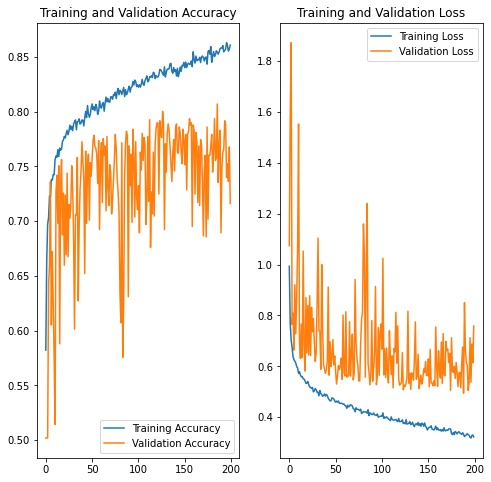

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
test_normal_path = "chest_xray/train/NORMAL/"
test_bacterial_path= "chest_xray/test/PNEUMONIA_BACTERIAL"
test_virus_path= "chest_xray/test/PNEUMONIA_VIRUS"

test_files_bacteria = [i for i in os.listdir(test_bacterial_path) if "bacteria" in i and path.isfile(path.join(test_bacterial_path, i))]
test_files_virus = [i for i in os.listdir(test_virus_path) if "virus" in i and path.isfile(path.join(test_virus_path, i))]
test_files_normal = [i for i in os.listdir(test_normal_path) if "NORMAL" in i and path.isfile(path.join(test_normal_path, i))]
img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[0]), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



In [20]:
count = 0
for index in range(len(test_files_normal)):
    img = tf.keras.utils.load_img(
    path.join(test_normal_path, test_files_normal[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "NORMAL":
        count+=1

        
print("Accuracy for normal = ", count/len(test_files_normal) *100, "%")


Accuracy for normal =  99.7340425531915 %


In [21]:
count = 0
diagnosed = 0
for index in range(len(test_files_bacteria)):
    img = tf.keras.utils.load_img(
    path.join(test_bacterial_path, test_files_bacteria[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
    

print("Accuracy for bacterial pneumonia = ", count/len(test_files_bacteria) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_bacteria) *100, "%")

Accuracy for bacterial pneumonia =  78.92561983471074 %
Accuracy for pneumonia =  95.86776859504133 %


In [22]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_virus_path, test_files_virus[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

Accuracy for viral pneumonia =  83.78378378378379 %
Accuracy for pneumonia =  95.27027027027027 %


In [23]:
!mkdir -p saved_model11
model.save('saved_model11/my_model')

INFO:tensorflow:Assets written to: saved_model10/my_model/assets


In [24]:
ls saved_model10/my_model

assets/            keras_metadata.pb  saved_model.pb     variables/


In [25]:
new_model = tf.keras.models.load_model('saved_model10/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)       

## First model batchsize = 64, dropout = 0.5
## Second model batchsize = 32, dropout =0.2
## Third model batchsize = 32, dropout =0.2
## Forth model batchsize = 32, dropout =0.2
## Fith model batchsize = 16, dropout = 0.2
## Sixth model batchsize = 8, dropout = 0.2

In [26]:
count = 0
diagnosed = 0
for index in range(len(test_files_virus)):
    img = tf.keras.utils.load_img(
    path.join(test_virus_path, test_files_virus[index]), target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = new_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        count+=1
    if class_names[np.argmax(score)] == "PNEUMONIA_BACTERIAL" or class_names[np.argmax(score)] == "PNEUMONIA_VIRUS":
        diagnosed+=1
print("Accuracy for viral pneumonia = ", count/len(test_files_virus) *100, "%")
print("Accuracy for pneumonia = ", diagnosed/len(test_files_virus) *100, "%")

Accuracy for viral pneumonia =  83.78378378378379 %
Accuracy for pneumonia =  95.27027027027027 %


In [27]:
with open("./result_model11.txt",'w') as f:
    for k in history.history.keys():
        print(k,file=f)
        for i in history.history[k]:
            print(i,file=f)

In [28]:
from collections import defaultdict
new_model_hist = defaultdict(list)
with open("./result_model11.txt",'r') as f:
    key = ""
    Lines = f.readlines()
    key_line = ["loss", "accuracy", "val_loss", "val_accuracy"]
    for line in Lines:
        line = line.strip()
        if  line in key_line:
            key = line
            print(key)
             
        else:
            new_model_hist[key].append(float(line))
#print(new_model_hist["loss"])
            
    
            

loss
accuracy
val_loss
val_accuracy
